# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:90%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:90%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
!wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

--2021-10-03 19:36:44--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813 [text/plain]
Saving to: ‘tiny_img.py’

tiny_img.py         100%[===================>]     813  --.-KB/s    in 0s      

2021-10-03 19:36:45 (17.4 MB/s) - ‘tiny_img.py’ saved [813/813]

--2021-10-03 19:36:45--  https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp drive/MyDrive/tiny_img.py tiny_img.py 
! cp drive/MyDrive/tiny_img_dataset.py tiny_img_dataset.py

In [4]:
#!L
from tiny_img import download_tinyImg200
data_path = '.'
download_tinyImg200(data_path)

Dataset was downloaded to './tiny-imagenet-200.zip'
Extract downloaded dataset to '.'


## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [5]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [6]:
train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     # you may add any other transforms here
     transforms.RandomAffine(5, scale=(0.9,1.1)),
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [7]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [8]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(list({item[1] for item in annotations})) 
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = tiny_img_dataset.read_rgb_image(img_name)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # take image and its target label from "self.images" and "self.targets", 
        # transform the image using self.transform and return the transformed image and its target label
        
        # YOUR CODE
        image = self.images[index]
        image = self.transform(image)
        target = self.targets[index]

        return image, target

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [9]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:06<00:00, 1580.65it/s]


For the most cases the default `DataLoader` will be good enough.

In [10]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=2)

In [11]:
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=2)

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [12]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [13]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, 
                              stride=stride, padding=kernel_size // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.relu(self.bn(self.conv(x)))
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module('block_%d_%d' %(block_index, layer_index_in_block), 
                             ConvBNRelu(in_channels, out_channels, 3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

In [14]:
model = create_vgg_like_network()
model = model.to(device)

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

In [14]:
#!L
def compute_loss(predictions, gt):
    return F.cross_entropy(predictions, gt).mean()

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

In [16]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

### 1.5 Training loop

Let's combine the previously defined things together.

In [15]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device) 
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)
        loss.backward()
        # backward
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)

        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [18]:
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]


Epoch 1 of 30 took 321.534s
  training loss (in-iteration): 	4.385545
  validation accuracy: 			11.66 %


100%|██████████| 1563/1563 [05:20<00:00,  4.88it/s]


Epoch 2 of 30 took 323.218s
  training loss (in-iteration): 	3.738406
  validation accuracy: 			17.55 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 3 of 30 took 324.222s
  training loss (in-iteration): 	3.421378
  validation accuracy: 			22.59 %


100%|██████████| 1563/1563 [05:19<00:00,  4.89it/s]


Epoch 4 of 30 took 322.317s
  training loss (in-iteration): 	3.215766
  validation accuracy: 			26.94 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 5 of 30 took 324.279s
  training loss (in-iteration): 	3.067345
  validation accuracy: 			29.25 %


100%|██████████| 1563/1563 [05:19<00:00,  4.89it/s]


Epoch 6 of 30 took 322.800s
  training loss (in-iteration): 	2.951477
  validation accuracy: 			32.06 %


100%|██████████| 1563/1563 [05:22<00:00,  4.85it/s]


Epoch 7 of 30 took 325.073s
  training loss (in-iteration): 	2.857216
  validation accuracy: 			31.65 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 8 of 30 took 324.416s
  training loss (in-iteration): 	2.782920
  validation accuracy: 			32.40 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 9 of 30 took 324.784s
  training loss (in-iteration): 	2.713938
  validation accuracy: 			36.07 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 10 of 30 took 324.485s
  training loss (in-iteration): 	2.652650
  validation accuracy: 			35.50 %


100%|██████████| 1563/1563 [05:20<00:00,  4.87it/s]


Epoch 11 of 30 took 323.830s
  training loss (in-iteration): 	2.606598
  validation accuracy: 			37.02 %


100%|██████████| 1563/1563 [05:21<00:00,  4.86it/s]


Epoch 12 of 30 took 324.398s
  training loss (in-iteration): 	2.559780
  validation accuracy: 			36.72 %


100%|██████████| 1563/1563 [05:25<00:00,  4.81it/s]


Epoch 13 of 30 took 328.119s
  training loss (in-iteration): 	2.520038
  validation accuracy: 			37.29 %


100%|██████████| 1563/1563 [05:23<00:00,  4.83it/s]


Epoch 14 of 30 took 326.302s
  training loss (in-iteration): 	2.483542
  validation accuracy: 			38.39 %


100%|██████████| 1563/1563 [05:17<00:00,  4.93it/s]


Epoch 15 of 30 took 319.918s
  training loss (in-iteration): 	2.446085
  validation accuracy: 			39.09 %


100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Epoch 16 of 30 took 319.348s
  training loss (in-iteration): 	2.416063
  validation accuracy: 			39.09 %


100%|██████████| 1563/1563 [05:15<00:00,  4.96it/s]


Epoch 17 of 30 took 318.119s
  training loss (in-iteration): 	2.394697
  validation accuracy: 			39.98 %


100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Epoch 18 of 30 took 319.381s
  training loss (in-iteration): 	2.363388
  validation accuracy: 			40.61 %


100%|██████████| 1563/1563 [05:16<00:00,  4.93it/s]


Epoch 19 of 30 took 319.613s
  training loss (in-iteration): 	2.336045
  validation accuracy: 			40.27 %


100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]


Epoch 20 of 30 took 320.914s
  training loss (in-iteration): 	2.313806
  validation accuracy: 			40.24 %


100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]


Epoch 21 of 30 took 320.882s
  training loss (in-iteration): 	2.296942
  validation accuracy: 			40.42 %


100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Epoch 22 of 30 took 319.597s
  training loss (in-iteration): 	2.271834
  validation accuracy: 			41.44 %


100%|██████████| 1563/1563 [05:17<00:00,  4.92it/s]


Epoch 23 of 30 took 320.662s
  training loss (in-iteration): 	2.255610
  validation accuracy: 			41.54 %


100%|██████████| 1563/1563 [05:16<00:00,  4.93it/s]


Epoch 24 of 30 took 319.785s
  training loss (in-iteration): 	2.234449
  validation accuracy: 			41.62 %


100%|██████████| 1563/1563 [05:16<00:00,  4.94it/s]


Epoch 25 of 30 took 319.447s
  training loss (in-iteration): 	2.223155
  validation accuracy: 			38.44 %


100%|██████████| 1563/1563 [05:16<00:00,  4.93it/s]


Epoch 26 of 30 took 319.608s
  training loss (in-iteration): 	2.202646
  validation accuracy: 			42.36 %


100%|██████████| 1563/1563 [05:15<00:00,  4.95it/s]


Epoch 27 of 30 took 318.389s
  training loss (in-iteration): 	2.188334
  validation accuracy: 			41.57 %


100%|██████████| 1563/1563 [05:18<00:00,  4.91it/s]


Epoch 28 of 30 took 321.425s
  training loss (in-iteration): 	2.168311
  validation accuracy: 			42.60 %


100%|██████████| 1563/1563 [05:19<00:00,  4.89it/s]


Epoch 29 of 30 took 322.472s
  training loss (in-iteration): 	2.161891
  validation accuracy: 			42.61 %


100%|██████████| 1563/1563 [05:17<00:00,  4.92it/s]


Epoch 30 of 30 took 320.255s
  training loss (in-iteration): 	2.145410
  validation accuracy: 			42.48 %


## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [19]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        
        residual = self.relu2(self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x))))))
        
        if self.conv3 is not None:
            x = self.conv3(x)
            
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module('block_%d_%d' %(i, j), ResNetBlock2(in_channels, out_channels, 3, 1))
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [20]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

100%|██████████| 1563/1563 [06:11<00:00,  4.21it/s]


Epoch 1 of 30 took 381.383s
  training loss (in-iteration): 	4.739059
  validation accuracy: 			7.08 %


100%|██████████| 1563/1563 [06:10<00:00,  4.22it/s]


Epoch 2 of 30 took 380.544s
  training loss (in-iteration): 	4.153923
  validation accuracy: 			10.97 %


100%|██████████| 1563/1563 [06:10<00:00,  4.21it/s]


Epoch 3 of 30 took 381.034s
  training loss (in-iteration): 	3.824532
  validation accuracy: 			16.62 %


100%|██████████| 1563/1563 [06:12<00:00,  4.19it/s]


Epoch 4 of 30 took 382.766s
  training loss (in-iteration): 	3.592982
  validation accuracy: 			19.57 %


100%|██████████| 1563/1563 [06:15<00:00,  4.16it/s]


Epoch 5 of 30 took 385.796s
  training loss (in-iteration): 	3.425796
  validation accuracy: 			23.67 %


100%|██████████| 1563/1563 [06:17<00:00,  4.14it/s]


Epoch 6 of 30 took 387.164s
  training loss (in-iteration): 	3.290166
  validation accuracy: 			21.32 %


100%|██████████| 1563/1563 [06:16<00:00,  4.15it/s]


Epoch 7 of 30 took 386.983s
  training loss (in-iteration): 	3.173748
  validation accuracy: 			27.45 %


100%|██████████| 1563/1563 [06:14<00:00,  4.17it/s]


Epoch 8 of 30 took 384.936s
  training loss (in-iteration): 	3.077467
  validation accuracy: 			28.84 %


100%|██████████| 1563/1563 [06:13<00:00,  4.18it/s]


Epoch 9 of 30 took 383.693s
  training loss (in-iteration): 	2.988659
  validation accuracy: 			31.18 %


100%|██████████| 1563/1563 [06:10<00:00,  4.21it/s]


Epoch 10 of 30 took 380.907s
  training loss (in-iteration): 	2.915744
  validation accuracy: 			30.80 %


100%|██████████| 1563/1563 [06:12<00:00,  4.20it/s]


Epoch 11 of 30 took 382.312s
  training loss (in-iteration): 	2.847123
  validation accuracy: 			28.40 %


100%|██████████| 1563/1563 [06:15<00:00,  4.16it/s]


Epoch 12 of 30 took 385.865s
  training loss (in-iteration): 	2.787033
  validation accuracy: 			34.56 %


100%|██████████| 1563/1563 [06:17<00:00,  4.14it/s]


Epoch 13 of 30 took 387.256s
  training loss (in-iteration): 	2.725844
  validation accuracy: 			34.56 %


100%|██████████| 1563/1563 [06:13<00:00,  4.19it/s]


Epoch 14 of 30 took 383.192s
  training loss (in-iteration): 	2.674272
  validation accuracy: 			34.64 %


100%|██████████| 1563/1563 [06:14<00:00,  4.17it/s]


Epoch 15 of 30 took 384.710s
  training loss (in-iteration): 	2.628727
  validation accuracy: 			29.31 %


100%|██████████| 1563/1563 [06:14<00:00,  4.18it/s]


Epoch 16 of 30 took 384.197s
  training loss (in-iteration): 	2.577887
  validation accuracy: 			35.41 %


100%|██████████| 1563/1563 [06:15<00:00,  4.16it/s]


Epoch 17 of 30 took 385.535s
  training loss (in-iteration): 	2.544619
  validation accuracy: 			36.61 %


100%|██████████| 1563/1563 [06:15<00:00,  4.17it/s]


Epoch 18 of 30 took 385.237s
  training loss (in-iteration): 	2.501398
  validation accuracy: 			38.93 %


100%|██████████| 1563/1563 [06:14<00:00,  4.17it/s]


Epoch 19 of 30 took 384.830s
  training loss (in-iteration): 	2.469919
  validation accuracy: 			36.82 %


100%|██████████| 1563/1563 [06:13<00:00,  4.18it/s]


Epoch 20 of 30 took 383.542s
  training loss (in-iteration): 	2.430825
  validation accuracy: 			37.65 %


100%|██████████| 1563/1563 [06:13<00:00,  4.19it/s]


Epoch 21 of 30 took 383.120s
  training loss (in-iteration): 	2.398932
  validation accuracy: 			38.54 %


100%|██████████| 1563/1563 [06:14<00:00,  4.18it/s]


Epoch 22 of 30 took 384.122s
  training loss (in-iteration): 	2.372082
  validation accuracy: 			41.07 %


100%|██████████| 1563/1563 [06:13<00:00,  4.18it/s]


Epoch 23 of 30 took 383.562s
  training loss (in-iteration): 	2.342930
  validation accuracy: 			41.04 %


100%|██████████| 1563/1563 [06:18<00:00,  4.13it/s]


Epoch 24 of 30 took 388.477s
  training loss (in-iteration): 	2.321141
  validation accuracy: 			41.08 %


100%|██████████| 1563/1563 [06:17<00:00,  4.14it/s]


Epoch 25 of 30 took 387.360s
  training loss (in-iteration): 	2.296838
  validation accuracy: 			40.81 %


100%|██████████| 1563/1563 [06:16<00:00,  4.15it/s]


Epoch 26 of 30 took 386.761s
  training loss (in-iteration): 	2.270735
  validation accuracy: 			42.65 %


100%|██████████| 1563/1563 [06:16<00:00,  4.15it/s]


Epoch 27 of 30 took 387.147s
  training loss (in-iteration): 	2.245959
  validation accuracy: 			42.68 %


100%|██████████| 1563/1563 [06:24<00:00,  4.06it/s]


Epoch 28 of 30 took 394.731s
  training loss (in-iteration): 	2.226058
  validation accuracy: 			42.24 %


100%|██████████| 1563/1563 [06:16<00:00,  4.15it/s]


Epoch 29 of 30 took 386.750s
  training loss (in-iteration): 	2.203970
  validation accuracy: 			42.57 %


100%|██████████| 1563/1563 [06:16<00:00,  4.15it/s]


Epoch 30 of 30 took 386.430s
  training loss (in-iteration): 	2.183513
  validation accuracy: 			43.60 %


If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [16]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30)

  0%|          | 0/1563 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1563/1563 [05:39<00:00,  4.61it/s]


Epoch 1 of 30 took 342.515s
  training loss (in-iteration): 	4.692523
  validation accuracy: 			6.74 %


100%|██████████| 1563/1563 [05:40<00:00,  4.59it/s]


Epoch 2 of 30 took 344.178s
  training loss (in-iteration): 	4.152812
  validation accuracy: 			11.57 %


100%|██████████| 1563/1563 [05:39<00:00,  4.60it/s]


Epoch 3 of 30 took 342.965s
  training loss (in-iteration): 	3.864027
  validation accuracy: 			17.07 %


100%|██████████| 1563/1563 [05:45<00:00,  4.52it/s]


Epoch 4 of 30 took 349.282s
  training loss (in-iteration): 	3.637001
  validation accuracy: 			13.17 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 5 of 30 took 346.967s
  training loss (in-iteration): 	3.463698
  validation accuracy: 			23.47 %


100%|██████████| 1563/1563 [05:41<00:00,  4.57it/s]


Epoch 6 of 30 took 345.364s
  training loss (in-iteration): 	3.315392
  validation accuracy: 			24.72 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 7 of 30 took 347.291s
  training loss (in-iteration): 	3.182290
  validation accuracy: 			27.11 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 8 of 30 took 347.071s
  training loss (in-iteration): 	3.062183
  validation accuracy: 			28.36 %


100%|██████████| 1563/1563 [05:44<00:00,  4.54it/s]


Epoch 9 of 30 took 347.823s
  training loss (in-iteration): 	2.962588
  validation accuracy: 			29.91 %


100%|██████████| 1563/1563 [05:42<00:00,  4.56it/s]


Epoch 10 of 30 took 346.029s
  training loss (in-iteration): 	2.865929
  validation accuracy: 			30.70 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 11 of 30 took 346.629s
  training loss (in-iteration): 	2.782467
  validation accuracy: 			32.77 %


100%|██████████| 1563/1563 [05:46<00:00,  4.52it/s]


Epoch 12 of 30 took 349.797s
  training loss (in-iteration): 	2.709326
  validation accuracy: 			33.94 %


100%|██████████| 1563/1563 [05:45<00:00,  4.52it/s]


Epoch 13 of 30 took 349.153s
  training loss (in-iteration): 	2.637411
  validation accuracy: 			35.46 %


100%|██████████| 1563/1563 [05:42<00:00,  4.56it/s]


Epoch 14 of 30 took 346.007s
  training loss (in-iteration): 	2.582030
  validation accuracy: 			36.23 %


100%|██████████| 1563/1563 [05:41<00:00,  4.58it/s]


Epoch 15 of 30 took 344.936s
  training loss (in-iteration): 	2.523077
  validation accuracy: 			37.25 %


100%|██████████| 1563/1563 [05:44<00:00,  4.53it/s]


Epoch 16 of 30 took 348.238s
  training loss (in-iteration): 	2.473560
  validation accuracy: 			37.96 %


100%|██████████| 1563/1563 [05:44<00:00,  4.53it/s]


Epoch 17 of 30 took 348.345s
  training loss (in-iteration): 	2.426267
  validation accuracy: 			39.02 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 18 of 30 took 347.251s
  training loss (in-iteration): 	2.388147
  validation accuracy: 			38.77 %


100%|██████████| 1563/1563 [05:45<00:00,  4.52it/s]


Epoch 19 of 30 took 349.354s
  training loss (in-iteration): 	2.338582
  validation accuracy: 			38.48 %


100%|██████████| 1563/1563 [05:43<00:00,  4.56it/s]


Epoch 20 of 30 took 346.535s
  training loss (in-iteration): 	2.304282
  validation accuracy: 			39.30 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 21 of 30 took 347.362s
  training loss (in-iteration): 	2.271500
  validation accuracy: 			39.89 %


100%|██████████| 1563/1563 [05:41<00:00,  4.58it/s]


Epoch 22 of 30 took 345.107s
  training loss (in-iteration): 	2.242454
  validation accuracy: 			39.95 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 23 of 30 took 347.086s
  training loss (in-iteration): 	2.204864
  validation accuracy: 			39.08 %


100%|██████████| 1563/1563 [05:45<00:00,  4.53it/s]


Epoch 24 of 30 took 348.754s
  training loss (in-iteration): 	2.172259
  validation accuracy: 			40.64 %


100%|██████████| 1563/1563 [05:44<00:00,  4.53it/s]


Epoch 25 of 30 took 348.399s
  training loss (in-iteration): 	2.142976
  validation accuracy: 			40.91 %


100%|██████████| 1563/1563 [05:47<00:00,  4.50it/s]


Epoch 26 of 30 took 351.013s
  training loss (in-iteration): 	2.116396
  validation accuracy: 			40.87 %


100%|██████████| 1563/1563 [05:46<00:00,  4.52it/s]


Epoch 27 of 30 took 349.550s
  training loss (in-iteration): 	2.089648
  validation accuracy: 			40.94 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 28 of 30 took 347.038s
  training loss (in-iteration): 	2.063757
  validation accuracy: 			42.24 %


100%|██████████| 1563/1563 [05:44<00:00,  4.54it/s]


Epoch 29 of 30 took 347.914s
  training loss (in-iteration): 	2.042617
  validation accuracy: 			42.53 %


100%|██████████| 1563/1563 [05:43<00:00,  4.55it/s]


Epoch 30 of 30 took 347.103s
  training loss (in-iteration): 	2.018502
  validation accuracy: 			43.24 %


Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [17]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.43242436305732485


In [18]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch 
                X_batch_transformed = tta_transformations(X_batch).to(device)
                logits = model(X_batch_transformed)
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.mean(torch.stack(logits_per_transform, dim=-1), dim=-1)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [19]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    # YOUR CODE: add ColorJitter augmentation; probably it's good idea to reduce the parameters of 
    # jittering comparing to augmentation on train set in order to reduce variance
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05)
])

In [20]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:57<00:00,  2.71it/s]


Model accuracy with 3 forward runs is 0.43700238853503187


100%|██████████| 157/157 [01:33<00:00,  1.68it/s]


Model accuracy with 5 forward runs is 0.44018710191082805


100%|██████████| 157/157 [02:05<00:00,  1.25it/s]


Model accuracy with 7 forward runs is 0.44158041401273884


100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


Model accuracy with 9 forward runs is 0.44177945859872614


100%|██████████| 157/157 [03:48<00:00,  1.46s/it]


Model accuracy with 13 forward runs is 0.44257563694267515


100%|██████████| 157/157 [04:25<00:00,  1.69s/it]

Model accuracy with 15 forward runs is 0.4443670382165605


Let's visualize what we have computed

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

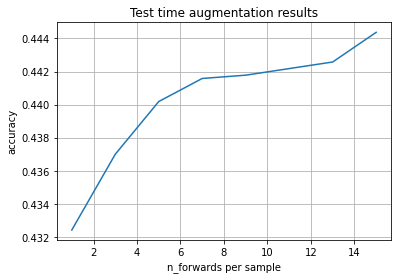

In [22]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape